## Лабораторная 1. KNN

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit

import optuna

In [57]:
df = pd.read_csv('dataframe.csv')
df.shape

(553, 9)

In [58]:
df.head()

,Процессор,"Общий объем SSD, ГБ",Видеокарта,Операционная система,"Диагональ экрана, дюймы",Технология матрицы,Тип памяти,Цена,"Оперативная память, ГБ"
0,Intel Core i5-1135G7 (2.4 ГГц),512.0,Intel Iris Xe Graphics,Без системы,15.6,TN,DDR4,50377,8
1,NaN,512.0,AMD Radeon R7,Windows Home,16.0,OLED,DDR4,61187,16
2,AMD Ryzen 7 5800H (3.2 ГГц),512.0,AMD Radeon Graphics,Без системы,16.0,OLED,DDR4,110081,16
3,Intel Core i7-13700HX (2.1 ГГц),1024.0,NVIDIA GeForce RTX 4060 для ноутбуков (8 Гб),Без системы,16.0,IPS,DDR5,135006,16
4,Intel Core i5-13500H (2.6 ГГц),512.0,Intel UHD Graphics,Windows Home,17.3,IPS,DDR4,60341,8


### Подготовка данных

In [59]:
df.isna().any()

Процессор                   True
Общий объем SSD, ГБ         True
Видеокарта                  True
Операционная система       False
Диагональ экрана, дюймы    False
Технология матрицы          True
Тип памяти                  True
Цена                       False
Оперативная память, ГБ     False
dtype: bool

In [60]:
edge_values = [df['Цена'].quantile(x) for x in [0.2, 0.4, 0.6, 0.8]]
edge_values

[50162.0, 55222.0, 65262.0, 90347.0]

In [61]:
def price_to_type(p):
    for i, edge in enumerate(edge_values):
        if p <= edge:
            return i
    return len(edge_values)

target = 'price_type'

df[target] = df['Цена'].apply(price_to_type)

df[target].value_counts()

price_type
0    115
1    112
4    110
3    110
2    106
Name: count, dtype: int64

In [62]:
num_columns = ['Диагональ экрана, дюймы', 'Общий объем SSD, ГБ', 'Оперативная память, ГБ']
cat_columns = ['Операционная система', 'Технология матрицы', 'Тип памяти', 'Процессор', 'Видеокарта']

In [63]:
X = df.drop([target, 'Цена'], axis=1)
y = df[target]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

In [64]:
class MyTransformer(BaseEstimator, TransformerMixin):
    frequent = {}

    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        for col in self.columns:
            self.frequent[col] = set(X[col].value_counts().head(4).index)
        return self

    def transform(self, X, y=None):
        for col in self.columns:
            X[col] = X[col].apply(lambda x: x if x in self.frequent[col] else 'OTHER')
        return X

num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

preprocessor = Pipeline(steps = [
    ('my_trans', MyTransformer(cat_columns)),
    ('column_trans', ColumnTransformer(
        transformers=[
            ("cat",
             OneHotEncoder(
                 handle_unknown="ignore"),
             cat_columns
            ),
            ("num", num_transformer, num_columns),
        ]
    ))
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_val = preprocessor.transform(X_val)

In [65]:
class KNN:
    """
    KNN classificator.
    Parameters:\\
    + distance =
        - euclidean
        - minkowsky (expects param p)
        - cosine
    + kernel = 
        - uniform
        - gaussian
        - triangular
        - epanechnikov
    + weights = None/array
    + k - number of neighbors
    + h - window width (only if k not specified)
    """

    def __init__(self, distance='euclidean', kernel='uniform', weights=None, k=None, h=None, **kwargs):
        
        if k is None and h is None:
            raise ValueError("At least k or h must be specified")
        
        self._weights = weights
        self._h = h
        self._k = k
        
        self._eps = 0.000001

        if distance == 'euclidean':
            self._distance = KNN.get_mikowsky_distance(2)
        elif distance == 'minkowsky':
            self._distance = KNN.get_mikowsky_distance(kwargs['p']) 
        elif distance == 'cosine':
            self._distance = KNN.cosine_distance
        else:
            raise ValueError('Wrong distance: ' + distance)
    
        if kernel == 'uniform':
            self._kernel = KNN.uniform_kernel
        elif kernel == 'gaussian':
            self._kernel = KNN.gaussian_kernel
        elif kernel == 'triangular':
            self._kernel = KNN.triangular_kernel
        elif kernel == 'epanechnikov':
            self._kernel = KNN.epanechnikov_kernel
        else:
            raise ValueError('Wrong kernel: ' + kernel)


    def fit(self, X, y):
        self._X = np.array(X)
        self._y = np.array(y)
        return self
    
    def predict(self, X):
        X = np.array(X)
        res = []
        for point in X:
            distances = []
            for i, train_point in enumerate(self._X):
                distances.append((self._distance(point, train_point), i))
            distances.sort()
            voting = {}
            for neighbor_number, (dist, idx) in enumerate(distances[:self._k]):
                if self._k is not None:
                    if neighbor_number == self._k: break
                    
                    value = self._kernel(dist / (distances[self._k][0] + self._eps))

                else: # use window with width h
                    value = self._kernel(dist / self._h)

                if self._weights is not None:
                    value *= self._weights[idx]

                target = self._y[idx]
                if target not in voting:
                    voting[target] = 0
                voting[target] += value
                     
            res.append(sorted(voting.items(), key=lambda x: x[1])[-1][0])
        return res

    @staticmethod
    def get_mikowsky_distance(p):
        def minkowsky(a, b):
            return np.sum(np.abs(a - b) ** p) ** (1/p)
        return minkowsky

    @staticmethod
    def cosine_distance(a, b):
        return 1 - np.sum(a * b) / (np.sum(a ** 2) * np.sum(b ** 2)) ** (1/2)
    
    @staticmethod
    def uniform_kernel(x):
        return 1 / 2 * (np.abs(x) < 1)
    
    @staticmethod
    def gaussian_kernel(x):
        return 1 / (2 * np.pi) ** (1/2) * np.exp(-x ** 2 / 2)
    
    @staticmethod
    def triangular_kernel(x):
        return (1 - np.abs(x)) * (np.abs(x) < 1)
    
    @staticmethod
    def epanechnikov_kernel(x):
        return 3 / 4 * (1 - x ** 2) * (np.abs(x) < 1)

In [66]:
knn = KNN(distance='euclidean', kernel='uniform', weights=None, k=5, h=None)
pred = knn.fit(X_train, y_train).predict(X_test)
accuracy_score(pred, y_test)

0.8558558558558559

### Сравнение с библиотечной

In [67]:
knn = KNeighborsClassifier(n_neighbors=5)
pred = knn.fit(X_train, y_train).predict(X_test)
accuracy_score(pred, y_test)

0.8558558558558559

### Разные метрики, ядра

In [68]:
tab = '    '
k = 5
h = 0.2
for metric in ['euclidean', 'minkowsky', 'cosine']:
    print(f'metric = {metric}')
    for kernel in ['uniform', 'gaussian', 'triangular', 'epanechnikov']:
        print(tab + f'kernel = {kernel}')
        score = accuracy_score(
            KNN(distance=metric, kernel=kernel, weights=None, k=k, h=None, p=4)\
                .fit(X_train, y_train)\
                .predict(X_test),
            y_test
        )
        print(tab * 2 + f'with k = {k}: {score}')
        score = accuracy_score(
            KNN(distance=metric, kernel=kernel, weights=None, k=None, h=h, p=4)\
                .fit(X_train, y_train)\
                .predict(X_test),
            y_test
        )
        print(tab * 2 + f'with h = {h}: {score}')

metric = euclidean
    kernel = uniform
        with k = 5: 0.8558558558558559
        with h = 0.2: 0.8828828828828829
    kernel = gaussian
        with k = 5: 0.9099099099099099
        with h = 0.2: 0.9009009009009009
    kernel = triangular
        with k = 5: 0.9099099099099099
        with h = 0.2: 0.8828828828828829
    kernel = epanechnikov
        with k = 5: 0.9099099099099099
        with h = 0.2: 0.8828828828828829
metric = minkowsky
    kernel = uniform
        with k = 5: 0.8558558558558559
        with h = 0.2: 0.8828828828828829
    kernel = gaussian
        with k = 5: 0.9099099099099099
        with h = 0.2: 0.9009009009009009
    kernel = triangular
        with k = 5: 0.9099099099099099
        with h = 0.2: 0.8828828828828829
    kernel = epanechnikov
        with k = 5: 0.9099099099099099
        with h = 0.2: 0.8828828828828829
metric = cosine
    kernel = uniform
        with k = 5: 0.8558558558558559
        with h = 0.2: 0.5495495495495496
    kernel = gaussi

### Optuna

In [69]:
def objective(trial):
    params = {
        'distance': trial.suggest_categorical('distance', ['euclidean', 'minkowsky', 'cosine']),
        'p': trial.suggest_float('p', 0.1, 5),
        'kernel': trial.suggest_categorical('kernel', ['uniform', 'gaussian', 'triangular', 'epanechnikov']),
        'k': trial.suggest_int('k', 1, 20)
        # 'h': trial.suggest_float('h', 0.0001, 10)
    }
    
    model = KNN(**params)

    return accuracy_score(y_val, model.fit(X_train, y_train).predict(X_val))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(study.best_params)
print(accuracy_score(y_val, KNN(**study.best_params).fit(X_train, y_train).predict(X_val)))

[I 2024-04-03 20:48:03,530] A new study created in memory with name: no-name-874a1c0f-ef3b-4ba5-b10d-ab8b9a6f0fc4


[I 2024-04-03 20:48:03,813] Trial 0 finished with value: 0.9325842696629213 and parameters: {'distance': 'cosine', 'p': 0.4604241818194522, 'kernel': 'triangular', 'k': 16}. Best is trial 0 with value: 0.9325842696629213.
[I 2024-04-03 20:48:04,089] Trial 1 finished with value: 0.8764044943820225 and parameters: {'distance': 'cosine', 'p': 2.086536272652475, 'kernel': 'gaussian', 'k': 10}. Best is trial 0 with value: 0.9325842696629213.
[I 2024-04-03 20:48:04,220] Trial 2 finished with value: 0.9325842696629213 and parameters: {'distance': 'euclidean', 'p': 1.6933719559387597, 'kernel': 'gaussian', 'k': 5}. Best is trial 0 with value: 0.9325842696629213.
[I 2024-04-03 20:48:04,350] Trial 3 finished with value: 0.797752808988764 and parameters: {'distance': 'euclidean', 'p': 1.9810113446084636, 'kernel': 'gaussian', 'k': 19}. Best is trial 0 with value: 0.9325842696629213.
[I 2024-04-03 20:48:04,523] Trial 4 finished with value: 0.7415730337078652 and parameters: {'distance': 'minkowsky

{'distance': 'minkowsky', 'p': 4.170070550307025, 'kernel': 'epanechnikov', 'k': 20}
0.9662921348314607


In [70]:
def objective(trial):
    params = {
        'distance': trial.suggest_categorical('distance', ['euclidean', 'minkowsky', 'cosine']),
        'p': trial.suggest_float('p', 0.1, 5),
        'kernel': trial.suggest_categorical('kernel', ['uniform', 'gaussian', 'triangular', 'epanechnikov']),
        # 'k': trial.suggest_int('k', 1, 20)
        'h': trial.suggest_float('h', 0.0001, 10)
    }
    
    model = KNN(**params)

    return accuracy_score(y_val, model.fit(X_train, y_train).predict(X_val))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(study.best_params)
print(accuracy_score(y_val, KNN(**study.best_params).fit(X_train, y_train).predict(X_val)))

[I 2024-04-03 20:48:07,475] A new study created in memory with name: no-name-cb8ca44d-76e7-4c89-bb1e-3bf3ee0341ea
[I 2024-04-03 20:48:07,680] Trial 0 finished with value: 0.6404494382022472 and parameters: {'distance': 'euclidean', 'p': 3.1353722827876367, 'kernel': 'triangular', 'h': 3.3966709237143586}. Best is trial 0 with value: 0.6404494382022472.
[I 2024-04-03 20:48:07,886] Trial 1 finished with value: 0.2247191011235955 and parameters: {'distance': 'minkowsky', 'p': 2.6563933426302055, 'kernel': 'epanechnikov', 'h': 9.489903200245674}. Best is trial 0 with value: 0.6404494382022472.
[I 2024-04-03 20:48:08,057] Trial 2 finished with value: 0.24719101123595505 and parameters: {'distance': 'euclidean', 'p': 4.908687710580791, 'kernel': 'gaussian', 'h': 6.085697177181185}. Best is trial 0 with value: 0.6404494382022472.
[I 2024-04-03 20:48:08,231] Trial 3 finished with value: 0.39325842696629215 and parameters: {'distance': 'euclidean', 'p': 4.983887081618501, 'kernel': 'epanechniko

{'distance': 'euclidean', 'p': 2.5878455684053487, 'kernel': 'uniform', 'h': 0.7221433138010168}
0.9775280898876404


In [71]:
def objective(trial):
    params = {
        'distance': trial.suggest_categorical('distance', ['euclidean', 'minkowsky', 'cosine']),
        'p': trial.suggest_float('p', 0.1, 5),
        'k': trial.suggest_int('k', 1, 20)
    }
    
    model = KNN(**params)

    return accuracy_score(y_val, model.fit(X_train, y_train).predict(X_val))

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(study.best_params)
print(accuracy_score(y_val, KNN(**study.best_params).fit(X_train, y_train).predict(X_val)))

[I 2024-04-03 20:48:12,379] A new study created in memory with name: no-name-28238deb-6edf-43c4-be85-9e6c233ab09c
[I 2024-04-03 20:48:12,520] Trial 0 finished with value: 0.4943820224719101 and parameters: {'distance': 'euclidean', 'p': 3.487907560824338, 'k': 20}. Best is trial 0 with value: 0.4943820224719101.
[I 2024-04-03 20:48:12,811] Trial 1 finished with value: 0.5842696629213483 and parameters: {'distance': 'cosine', 'p': 2.9019227144409565, 'k': 18}. Best is trial 1 with value: 0.5842696629213483.
[I 2024-04-03 20:48:12,947] Trial 2 finished with value: 0.898876404494382 and parameters: {'distance': 'euclidean', 'p': 3.6616068538701207, 'k': 5}. Best is trial 2 with value: 0.898876404494382.
[I 2024-04-03 20:48:13,227] Trial 3 finished with value: 0.6404494382022472 and parameters: {'distance': 'cosine', 'p': 3.6730512666738457, 'k': 16}. Best is trial 2 with value: 0.898876404494382.
[I 2024-04-03 20:48:13,507] Trial 4 finished with value: 0.9325842696629213 and parameters: {

{'distance': 'cosine', 'p': 4.870824980847477, 'k': 1}
0.9775280898876404


### Graphics

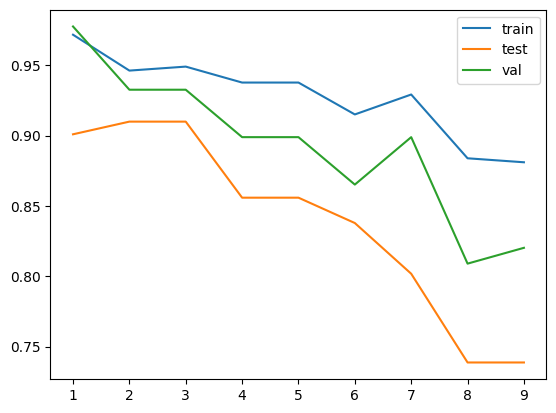

In [72]:
k_range = np.arange(1, 10)
acc_train = []
acc_test = []
acc_val = []

for k in k_range:
    model = KNN(distance='cosine', p=3.6152173189555747, k=k)
    model.fit(X_train, y_train)

    acc_train.append(accuracy_score(y_train, model.predict(X_train)))
    acc_test.append(accuracy_score(y_test, model.predict(X_test)))
    acc_val.append(accuracy_score(y_val, model.predict(X_val)))

plt.plot(k_range, acc_train, label='train')
plt.plot(k_range, acc_test, label='test')
plt.plot(k_range, acc_val, label='val')
plt.legend();

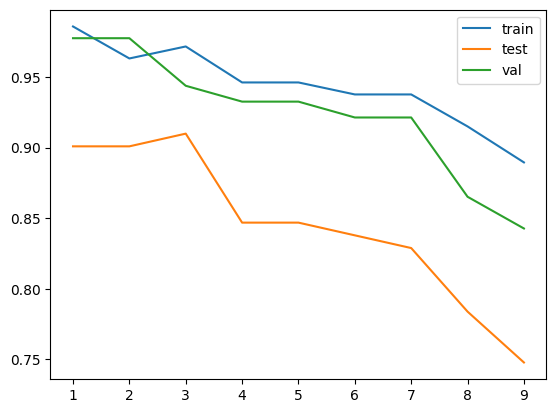

In [73]:
k_range = np.arange(1, 10)
acc_train = []
acc_test = []
acc_val = []

for k in k_range:
    model = KNeighborsClassifier(metric='cosine', p=3.6152173189555747, n_neighbors=k)
    model.fit(X_train, y_train)

    acc_train.append(accuracy_score(y_train, model.predict(X_train)))
    acc_test.append(accuracy_score(y_test, model.predict(X_test)))
    acc_val.append(accuracy_score(y_val, model.predict(X_val)))

plt.plot(k_range, acc_train, label='train')
plt.plot(k_range, acc_test, label='test')
plt.plot(k_range, acc_val, label='val')
plt.legend();

### LOWESS

In [74]:

def lowess(X, y, knn, kernel='uniform'):
    if kernel == 'uniform':
        kernel = KNN.uniform_kernel
    elif kernel == 'gaussian':
        kernel = KNN.gaussian_kernel
    elif kernel == 'triangular':
        kernel = KNN.triangular_kernel
    elif kernel == 'epanechnikov':
        kernel = KNN.epanechnikov_kernel
    else:
        raise ValueError('Wrong kernel: ' + kernel)
    
    weights = []
    for i in range(len(X)):
        new_X = np.delete(X, i, axis=0)
        new_y = np.delete(y, i, axis=0)
        knn.fit(new_X, new_y)
        
        y_pred = knn.predict(np.array([X[i]]))[0]
        weights.append(kernel(0 if y[i] == y_pred else 1))
    
    return weights

In [95]:
model = KNN(k=4)
model.fit(X_train, y_train)
print(accuracy_score(y_test, model.predict(X_test)))

0.8558558558558559


In [98]:
w = lowess(X_train, y_train.values, model, kernel='uniform')

In [99]:
model = KNN(k=4, weights=w)
model.fit(X_train, y_train)
print(accuracy_score(y_test, model.predict(X_test)))

0.8468468468468469
